# Basic Concepts of Radiometry

We need to establish and clarify some basic concepts of Radiometry before we proceed further. 

While we will show some coding examples, these mechanics are mostly buried in the `Light` and `LightSource` objects. See [this notebook](light.ipynb) to see these objects in action.

As the basic terminology, Exitance is the power "exiting" per unit emitter area. Irradiance (or Illuminance in Photometry) is the "incoming" power per unit "illuminated" surface area. These are measured in Watt/m<sup>2</sup> and they correspond to the flux perpendicular to an area (either on the source or on the receiver). Radiance (or Luminance in Photometry) has an additional directional quality and is measured in Watt/m<sup>2</sup>/sr.

The notation here closely follows the one defined in [Wikipedia](https://en.wikipedia.org/wiki/Irradiance#SI_radiometry_units).

We have to start with the opticks package import as well as some other useful packages.

In [1]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", "..", ".."))
    os.getcwd()

In [2]:
import numpy as np

from opticks import u, Q_, P

from astropy.visualization import quantity_support

quantity_support()

%matplotlib inline

from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("always")

## Spectral Radiance: The Spectrum of the Radiated Power Leaving a Surface

A simple example is the [Planck's Law](https://en.wikipedia.org/wiki/Planck's_law), that describes a spherically uniform radiated power, which is the function of the wavelength and the surface temperature only. 

$$ L_\lambda = 
    \frac{2 h c^2}{\lambda^5}
    \frac{1}{e^{hc / \lambda k T} - 1}
$$

The unit is $W/(sr. m^2 . nm)$, meaning that the [Spectral Radiance](https://en.wikipedia.org/wiki/Spectral_radiance) defined: 
1. represents the power output, 
2. from a unit [solid angle](https://en.wikipedia.org/wiki/Solid_angle) (given in steradians) on the emitter,
3. for each unit wavelength (the $nm$ part),
4. impinging on a target surface at a distance and normal to the radiation vector with a unit area (the $m^2$ part).

As an example, we can illustrate modelling the Sun as a 5778 K blackbody.

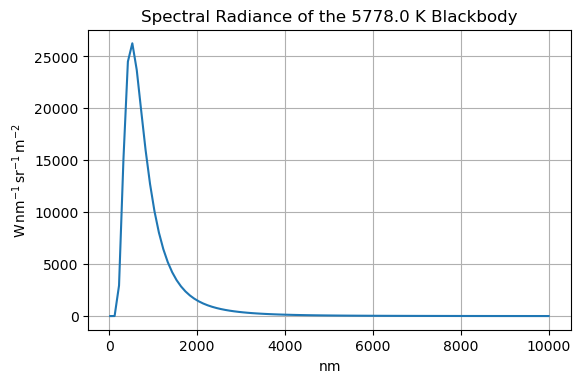

In [3]:
from astropy import constants as const

from opticks.utils.interval_data import (
    FunctCombinationMethod,
    IntervalData,
    IntervalDataPlot,
)
from opticks.utils.math_utils import InterpolatorWithUnits, InterpolatorWithUnitTypes

# setup
# ****************************
begin = 20 * u.nm
end = 10000 * u.nm

wvl_range = P.closed(begin, end)

sample_size = 8000

T = 5778 * u.K

# generate the spectral radiance data
# ****************************

# generate wavelength values
wvl = np.linspace(wvl_range.lower, wvl_range.upper, num=sample_size, endpoint=True)

# shorthands for the constants
c = const.c
k_B = const.k_B
h = const.h

with u.set_enabled_equivalencies(u.dimensionless_angles()):
    # spectral radiance (L_wvl): Planck's law of blackbody radiation
    top = 2 * h * c**2 / wvl**5
    bottom = np.exp(h * c / (wvl * k_B * T)) - 1
    spec_radiance = (top / bottom).decompose().to("W/(m^2 . sr. nm)")

spec_radiance_model = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.AKIMA, wvl, spec_radiance, extrapolate=True
)

full_spectrum_radiance = IntervalData({wvl_range: spec_radiance_model})

# generate the plot
plot = full_spectrum_radiance.plot()

plot.set_plot_style(title=f"Spectral Radiance of the {T} Blackbody", legend_off=True)

## Spectral Irradiance: Flux Density on the Target Surface

The Spectral Radiance defined in the previous section described the power output of a small (differential) solid angle surface (on the emitter), but didn't quite explain how to calculate the flux at a distance. Flux in this context means the component of the power radiated by the blackbody impinging vertically on a unit area target surface. Spectral Irradiance therefore starts from Spectral Radiance and then computes the geometric shape of the radiating surface (or more generally the Wavefront) and the "rays" out of radiating surfaces to compute the outward flux. 

The first part is to compute how much of the isotropic emitter that the target surface "sees". The easy answer is just one half of the spherical radiation, or $2\pi$ steradians of solid angle.

The more proper (or general) explanation requires thinking a bit in terms of the geometry of the problem. An arbitrary solid angle is given by the double integral:

$$ \int d\omega = \int \int \sin \theta d\theta d\varphi $$

where $\theta$ is the colatitude (angle from the North Pole) and $\varphi$ is the longitude. The definite integral is straightforward.

$$ \int_{\theta_0}^{\theta_1} \int_{\varphi_0}^{\varphi_1} \sin \theta d\theta d\varphi = \left( -\cos\theta_1 - \cos\theta_0 \right) . (\varphi_1 - \varphi_0)$$

As the target surface sees only one hemisphere, the longitude $\varphi$ is defined from 0 to 360 degrees, and the colatitude $\theta$ is defined from 0 to 90 degrees. Plugging the values (in radians), we can see that the solid angle is indeed $2\pi$ steradians.

In [4]:
# 4 pi steradian is the full sphere
# phi 0 to 2pi
# th 0 to pi

# for the generic definition
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (90 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)


def solid_angle(phi1, phi0, th1, th0):
    return (phi1 - phi0) * (-(np.cos(th1) - np.cos(th0)) * u.rad)


solid_ang = solid_angle(phi1, phi0, th1, th0)

with u.set_enabled_equivalencies(u.dimensionless_angles()):
    print(
        f"Solid angle: {solid_ang.to(u.sr):.5} ({solid_ang.to_value(u.rad) / np.pi:.5} x pi)"
    )

Solid angle: 6.2832 sr (2.0 x pi)


However, the flux definition requires us to compute the normal components of the spectral radiance for each small (or differential) emitting area, which adds a $\cos\theta$ to the integral:

$$ \int \cos\theta d\omega = \int \int \cos \theta \sin \theta d\theta d\varphi $$

The solution requires one intermediate step ($u=\sin\theta$ substitution) but is still not terribly difficult.

$$ \int_{\theta_0}^{\theta_1} \int_{\varphi_0}^{\varphi_1} \cos \theta \sin \theta d\theta d\varphi = \frac{1}{2} \left( \sin^2\theta_1 - \sin^2\theta_0 \right) . (\varphi_1 - \varphi_0)$$


In [5]:
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (90 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)


def flux_coeff(phi1, phi0, th1, th0):
    return ((phi1 - phi0) * 1 / 2 * (np.sin(th1) ** 2 - np.sin(th0) ** 2) * u.rad).to(
        u.sr
    )


geom_coeff = flux_coeff(phi1, phi0, th1, th0)


with u.set_enabled_equivalencies(u.dimensionless_angles()):
    print(
        f"Geometric coefficient for the flux: {geom_coeff.to(u.sr)} ({geom_coeff.to_value(u.rad) / np.pi} x pi)"
    )

Geometric coefficient for the flux: 3.141592653589793 sr (1.0 x pi)


Spectral Irradiance or Spectral Flux Density is therefore:

$$E_\lambda = \int L_\lambda \cos \theta d\omega = L_\lambda \int  \cos \theta d\omega$$

where the integral is essentially the "geometric flux coefficient" computed above. 

Summarising, the Spectral Irradiance, or the power through the unit area per unit wavelength (of the blackbody) is:

$$ E_\lambda = \pi L_\lambda = 
    \frac{2 \pi h c^2}{\lambda^5}
    \frac{1}{e^{hc / \lambda k T} - 1}
$$

where the unit is W/m<sup>2</sup>/nm.

More generally, the $ E_\lambda = \pi L_\lambda$ equation holds for all Lambertian emitters (see [Lambert's Cosine Law](https://en.wikipedia.org/wiki/Lambert%27s_cosine_law)).

Finally, we can plot the Spectral Irradiance curve.

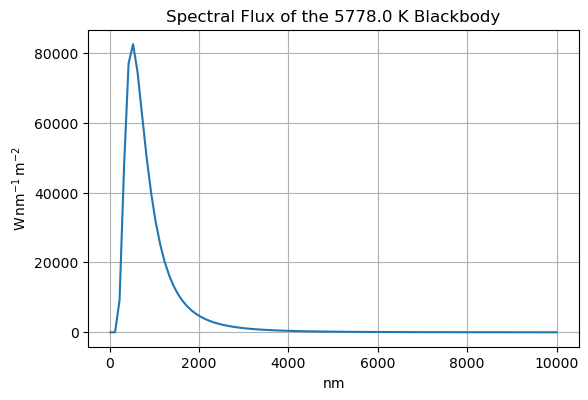

In [6]:
spec_flux = full_spectrum_radiance.scale(geom_coeff)

# generate the plot

plot = IntervalDataPlot({"spec_flux": spec_flux}, apply_default_style=False)

plot.set_plot_style(title=f"Spectral Flux of the {T} Blackbody", legend_off=True)

## Radiant and Spectral Exitance: Power Output of a Source

The Spectral Irradiance (or Spectral Flux Density) defined above can be seen as the power output out of an radiating body (or Spectral Exitance). In this example, as we set up the source as a blackbody, we can compute the Exitance and check it against the theory.

The Radiant Exitance of a blackbody is given as $\sigma T^4$, which is the integration of the power in all wavelengths. Therefore, we can equally integrate the Spectral Irradiance.

In [7]:
# Stefan-Boltzmann constant
s = const.sigma_sb

# radiant exitance: M = s.T**4
M = s * T**4

print(M)

print(spec_flux.integrate().to("W/m^2"))

63200699.73684546 W / m2
63118559.7576714 W / m2


The (small) difference is due to the limited wavelength of the Spectral Irradiance definition above.

## Radiant Power, Total Flux and Flux at a Distance

We can now define the propagation of light in free space. In this example, the surface of the Sun is the blackbody and we can compute the flux at the Earth.

First we compute the Radiant Power on the surface of the blackbody sphere. This Radiant Power is also called Luminosity or, in this case,the Solar Luminosity.

3.838936701582524e+26 W


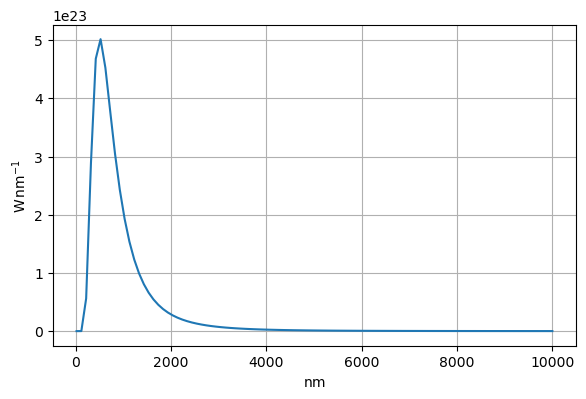

In [8]:
r_sun = (695700 * u.km).to(u.m)

# area of the sphere
area_sphere = 4 * np.pi * r_sun**2

spectral_radiant_power = spec_flux.scale(area_sphere)

print(spectral_radiant_power.integrate().to("W"))

# flux at the surface of the sun
spectral_radiant_power.plot()

The same power reaches the Earth distance, though now the radius of the sphere is the size of 1 AU or about 150 million km.

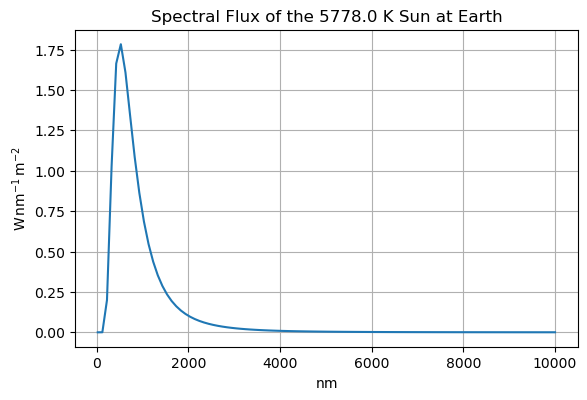

In [9]:
# propagate in free space towards the Earth ToA
distance = (1 * u.au).to(u.m)

# area of the sphere
area_sphere = 4 * np.pi * distance**2

spec_flux_at_earth = spectral_radiant_power.scale(1 / area_sphere)


# generate the plot
plot = IntervalDataPlot(
    {"spec_flux_at_earth": spec_flux_at_earth}, apply_default_style=False
)

plot.set_plot_style(title=f"Spectral Flux of the {T} Sun at Earth", legend_off=True)

We could have skipped the intermediate step of computing the total power output on the Sun's surface. 

$$ \text{spectral flux at Earth} = \text{spectral flux at Sun} \times \frac{r^2_{Sun}}{r^2_{Sun-Earth}} $$

Finally, we can integrate over the wavelengths to compute the total flux. The true value is around 1366 W/m<sup>2</sup>.

This is called the [Irradiance or Flux Density](https://en.wikipedia.org/wiki/Flux_density).

In [10]:
spec_flux_at_earth.integrate().to("W/m^2")

<Quantity 1365.05535554 W / m2>

## Links to Photometry

[Photometry](https://en.wikipedia.org/wiki/Photometry_(optics)) is similar to radiometry, though it is more focussed on light and its perceived brightness to the human eye. Fundamental to Photometry is the [Luminous Efficiency Function](https://en.wikipedia.org/wiki/Luminous_efficiency_function), which models human brightness sensitivity and is essentially a spectral weighting factor applied to the radiant power.

Therefore, the wavelengths outside the human vision are much less relevant to Photometry. [(Spectral) Luminous Efficacy](https://en.wikipedia.org/wiki/Luminous_efficacy) converts the radiant power in Watts to lumens, and its value is reduced when some of the radiant power lies outside the visible domain.

Regarding the terminology, (Spectral) Radiance is equivalent to Luminance in Photometry. Similarly, (Spectral) Irradiance is equivalent to Illuminance and (Spectral) Exitance is equivalent to the Luminous Exitance.

## Lighting Example

We can have a look at an example with a LED light. LEDs are usually very narrow in wavelength, though it is possible combine them to generate a wide bandwidth light. 

First we create the Spectral Radiant Power of [a sample LED](https://www.ledlightexpert.com/understanding_led_light_color_temperatures_ep_79). The data is given in relative intensity, though we will convert it to power with a scaling coefficient.

Note that, in general, the energy efficiency of LED lamps are about 30 to 40%. A full 100% efficiency would correspond to 350 lm/W. 

Let's consider a 75W LED lamp, which would have a radiant power of about 30W. We therefore choose a power scale of 0.135W/nm.


Total radiant power: 29.694 W


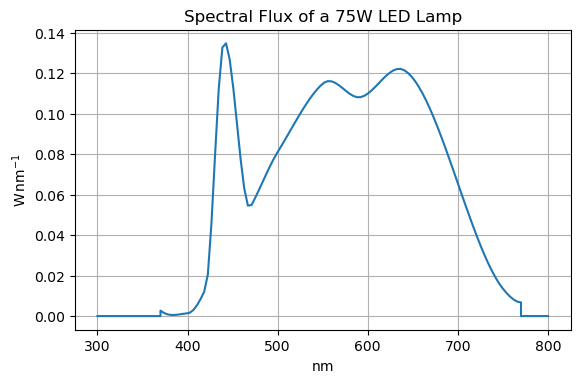

In [11]:
data = P.IntervalDict()
# interval of validity
data[P.closed(300 * u.nm, 800 * u.nm)] = 0
# data proper
x = [370, 400, 420, 440, 470, 500, 550, 590, 640, 750, 770] * u.nm
y = [0.02, 0.01, 0.1, 1.0, 0.4, 0.6, 0.85, 0.8, 0.9, 0.1, 0.05]
sub_range = P.closed(x[0], x[-1])

ipol = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.AKIMA, x, y, extrapolate=True
)

# this is the relative intensity data
data[sub_range] = ipol

power_scale = 0.135 * u.W / u.nm

spectral_radiant_flux = IntervalData(data).scale(power_scale)


# plot the data
spectral_radiant_flux.plot().set_plot_style(
    title="Spectral Flux of a 75W LED Lamp", legend_off=True
)

print(f"Total radiant power: {spectral_radiant_flux.integrate():.5}")

The next question is the goniometry, or the radiation pattern of the lamp. We will look at three cases:

1. Fully spherical radiation pattern
2. 120 degree cone
3. 20 degree cone

The power is distributed over a smaller surface for each case.

In [12]:
r = 1 * u.m

# Case 1: fully spherical
# ****************************

# solid angle: sphere
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (180 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)

solid_ang = solid_angle(phi1, phi0, th1, th0)

area = (solid_ang * r**2).to("m^2", equivalencies=u.dimensionless_angles())

spec_flux_sphere = spectral_radiant_flux.scale(1 / area)

print(f"Irradiance at 1m distance: {spec_flux_sphere.integrate()} (sphere)")

# Case 2: 120 deg cone
# ****************************

# solid angle: 120 deg cone
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (60 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)

solid_ang = solid_angle(phi1, phi0, th1, th0)

area = (solid_ang * r**2).to("m^2", equivalencies=u.dimensionless_angles())

spec_flux_120_deg = spectral_radiant_flux.scale(1 / area)

print(f"Irradiance at 1m distance: {spec_flux_120_deg.integrate()} (120 deg cone)")

# Case 3: 20 deg cone
# ****************************

# solid angle: 120 deg cone
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (10 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)

solid_ang = solid_angle(phi1, phi0, th1, th0)

area = (solid_ang * r**2).to("m^2", equivalencies=u.dimensionless_angles())

spec_flux_20_deg = spectral_radiant_flux.scale(1 / area)

print(f"Irradiance at 1m distance: {spec_flux_20_deg.integrate()} (120 deg cone)")

Irradiance at 1m distance: 2.3629361817705012 W / m2 (sphere)
Irradiance at 1m distance: 9.451744727082007 W / m2 (120 deg cone)
Irradiance at 1m distance: 311.0713225856959 W / m2 (120 deg cone)


As can be seen, the same power is concentrated over a smaller area, increasing the flux dramatically.

These (Spectral) Irradiance (or Flux Density) computations are similar to Illuminance calculations in Photometry, except they concentrate on the visible domain via a weighting function.

## Conversion to Photometric Quantities

To be able to convert the data into Photometric quantities, we need to generate the Luminous Efficiency Function. We have retrieved the Photopic Response Function data from the [UCL CVRL website](http://www.cvrl.org/lumindex.htm), in this case _the CIE "physiologically-relevant" luminous efficiency functions consistent with the Stockman & Sharpe cone fundamentals_, given in 5 nm steps.    

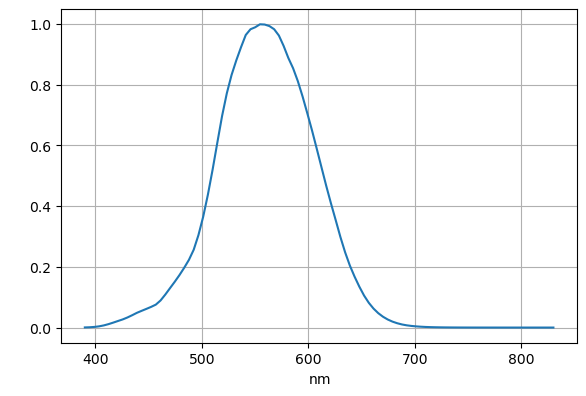

In [13]:
import csv

# Specify the file path
file_path = "opticks/radiometric_model/data/linCIE2008v2e_5.csv"


# Open the file in read mode
with open(file_path, "r") as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)

    # Iterate over each row in the CSV file
    wvl, efficiency = zip(*[(float(row[0]), float(row[1])) for row in csv_reader])

    wvl = wvl * u.nm

    # Init IntervalData
    range = P.closed(wvl[0], wvl[-1])
    ipol = InterpolatorWithUnits.from_ipol_method(
        InterpolatorWithUnitTypes.AKIMA, wvl, efficiency, extrapolate=True
    )

    lum_eff_funct = IntervalData.from_interpolator(ipol)

    lum_eff_funct.plot()

Now that we have the Luminous Efficiency Function, we can compute the Luminous Flux. It is given as the integral of the Luminous Efficiency Function multiplied by the Spectral Flux over the full wavelenghts, multiplied by the ideal conversion coefficient.

$$\Phi _{\mathrm {v} }=683.002\ (\mathrm {lm/W} )\cdot \int _{0}^{\infty }{\overline {y}}(\lambda )\Phi _{\mathrm {e} ,\lambda }(\lambda )\,\mathrm {d} \lambda $$

Luminous Flux: 8188.922296599875 lm


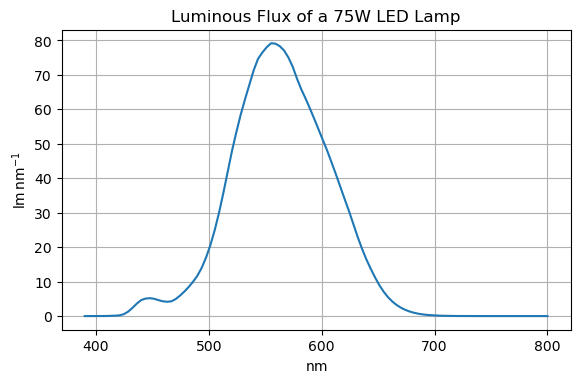

In [14]:
lum_eff_funct.combination_method = FunctCombinationMethod.MULTIPLY

lum_flux = spectral_radiant_flux.combine(lum_eff_funct).scale(683.002 * u.lm / u.W)

print(f"Luminous Flux: {lum_flux.integrate()}")

lum_flux.plot().set_plot_style(title="Luminous Flux of a 75W LED Lamp", legend_off=True)